In [1]:
import sys, os

# Replace 'path/to/folder' with the actual path to the folder you want to include
folder_path = '../models/'
if folder_path not in sys.path:
    sys.path.append(folder_path)

from cnmp import CNMP
from cnep import CNEP

import numpy as np
import torch
from movement_primitives.promp import ProMP
from movement_primitives.dmp import DMP
from gmr import GMM
import matplotlib.pyplot as plt

In [2]:
root_path = '/home/yigit/projects/cnep/outputs/'
test_path = 'ablation/sines_4/2_4_8/1714557588'

data_path = root_path + test_path + '/y.pt'

Y = torch.load(data_path).to('cpu').numpy().squeeze(-1)
x = np.linspace(0, 1, Y.shape[1])

sid = [0,32,64,96]
Y = Y[sid, :]

print(f'x: {x.shape}, Y: {Y.shape}')

x: (200,), Y: (4, 200)


In [3]:
d = DMP(n_dims=1, n_weights_per_dim=4, dt=1/Y.shape[1])

ind = 1
sp, ep = Y[ind, 0], Y[ind, -1]  # Start and end points

for i, traj in enumerate(Y):
    d.imitate(x, traj.reshape(-1,1))

d.configure(start_y=[sp], goal_y=[ep])
t, trajectory = d.open_loop()

p = ProMP(n_dims=1, n_weights_per_dim=4)
p.imitate(np.tile(x, (Y.shape[0], 1)), Y)
p = p.condition_position(sp, t=0).condition_position(ep, t=1)
trajectory_p = p.sample_trajectories(x, 1, np.random.RandomState(seed=1234))

input_data = x.reshape(-1, 1)  # Phase variable as a column vector

priors = 4  # Number of GMM components
gmr_model = GMM(n_components=priors, random_state=1234)
gmr_model.from_samples(Y)
gmr_model = gmr_model.condition([0, -1], [sp, ep])
trajectory_g = gmr_model.sample(1)
trajectory_g = np.insert(trajectory_g, 0, sp)
trajectory_g = np.append(trajectory_g, ep)

In [4]:
print(trajectory.shape)

(201, 1)


In [5]:
root_path = "/home/yigit/projects/cnep/outputs/sine/4_sine/cnmp_cnep/"
run_id, model_folder = '1715584279', '/saved_models/'
models_path = f'{root_path}{run_id}{model_folder}'

cnmp_path, cnep_path = f'{models_path}cnmp.pt', f'{models_path}cnep.pt'

batch_size = 1
dx, dy = 1, 1
n_max, m_max = 10, 10
t_steps = 200
device = 'cpu'
cnmp = CNMP(dx, dy, n_max, m_max, [104,104], decoder_hidden_dims=[104,104], batch_size=batch_size, device=device)
cnep = CNEP(dx, dy, n_max, m_max, [64,64], num_decoders=4, decoder_hidden_dims=[64, 64], batch_size=batch_size, scale_coefs=True, device=device)

cnmp.load_state_dict(torch.load(cnmp_path))
cnep.load_state_dict(torch.load(cnep_path))

<All keys matched successfully>

In [6]:
val_obs = torch.zeros((batch_size, n_max, dx+dy), dtype=torch.float32, device=device)
val_tar_x = torch.zeros((batch_size, t_steps, dx), dtype=torch.float32, device=device)
# val_tar_y = torch.zeros((batch_size, t_steps, dy), dtype=torch.float32, device=device)
val_obs_mask = torch.zeros((batch_size, n_max), dtype=torch.bool, device=device)

val_obs.fill_(0)
val_tar_x.fill_(0)
val_obs_mask.fill_(False)

m_ids = torch.arange(t_steps)
i = 0

val_obs[i, :2, :dx] = torch.tensor([0, 0.995]).unsqueeze(1)
val_obs[i, :2, dx:] = torch.tensor([sp, ep]).unsqueeze(1)
val_obs_mask[i, :2] = True

val_tar_x[i] = (m_ids/t_steps).unsqueeze(1)

with torch.no_grad():
    trajectory_cnmp = cnmp.val(val_obs, val_tar_x, val_obs_mask)[:, :, :dy]
    trajectory_cnep, gate = cnep.val(val_obs, val_tar_x, val_obs_mask)
    dec_id = torch.argmax(gate.squeeze(1), dim=-1)
    vp_means = trajectory_cnep[dec_id, 0, :, :dy]

In [9]:
print(trajectory_cnmp, vp_means)

tensor([[[-5.0115e-03],
         [ 1.3575e-05],
         [ 5.0387e-03],
         [ 1.0064e-02],
         [ 1.5089e-02],
         [ 2.0114e-02],
         [ 2.5139e-02],
         [ 3.0164e-02],
         [ 3.5189e-02],
         [ 4.0215e-02],
         [ 4.5240e-02],
         [ 5.0265e-02],
         [ 5.5290e-02],
         [ 6.0315e-02],
         [ 6.5340e-02],
         [ 7.0365e-02],
         [ 7.5390e-02],
         [ 8.0416e-02],
         [ 8.5441e-02],
         [ 9.0466e-02],
         [ 9.5491e-02],
         [ 1.0052e-01],
         [ 1.0554e-01],
         [ 1.1057e-01],
         [ 1.1559e-01],
         [ 1.2062e-01],
         [ 1.2564e-01],
         [ 1.3067e-01],
         [ 1.3569e-01],
         [ 1.4072e-01],
         [ 1.4574e-01],
         [ 1.5077e-01],
         [ 1.5579e-01],
         [ 1.6082e-01],
         [ 1.6584e-01],
         [ 1.7087e-01],
         [ 1.7589e-01],
         [ 1.8092e-01],
         [ 1.8594e-01],
         [ 1.9097e-01],
         [ 1.9599e-01],
         [ 2.010

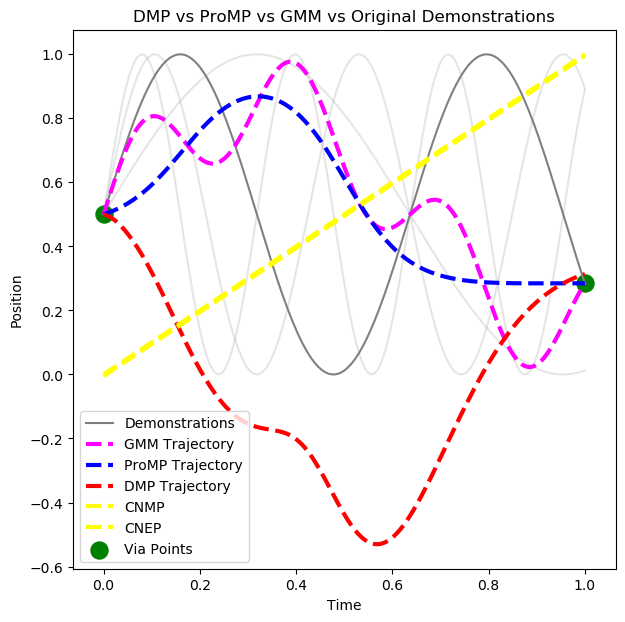

In [8]:
import seaborn as sns

colors = [sns.color_palette('tab10')[0], sns.color_palette('tab10')[1], sns.color_palette('tab10')[2], sns.color_palette('tab10')[3]]
sns.set_palette('tab10')

plt.rcParams['figure.figsize'] = [7, 7]

for i, t in enumerate(Y):
    if i == ind:
        plt.plot(x, t, color='gray', label='Demonstrations')
    else:
        plt.plot(x, t, color='gray', alpha=0.2)  # Original trajectories in gray


# Plot generated trajectories
plt.plot(x, trajectory_g, label='GMM Trajectory', color='magenta', linewidth=3, linestyle='dashed')
plt.plot(x, trajectory_p[0,:,0], label='ProMP Trajectory', color='blue', linewidth=3, linestyle='dashed')
plt.plot(x, trajectory[1:,:], label='DMP Trajectory', color='red', linewidth=3, linestyle='dashed')
plt.plot(x, trajectory_cnmp[0], label='CNMP', color='yellow', linewidth=3, linestyle='dashed')
plt.plot(x, vp_means[0], label='CNEP', color='yellow', linewidth=3, linestyle='dashed')

plt.scatter([0, 1], [sp, ep], color='green', label='Via Points', s=150)  # Via points
plt.legend(loc='lower left')
plt.title('DMP vs ProMP vs GMM vs Original Demonstrations')
plt.xlabel('Time')
plt.ylabel('Position')
plt.show()